In [8]:
import numpy as np

from scipy.stats import norm
from tqdm import tqdm
import os

from Chempy.parameter import ModelParameters

import sbi.utils as utils
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

import multiprocessing as mp
import matplotlib.pyplot as plt

In [4]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [30]:
# --- Set up the model ---
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x

model = Model_Torch()

# --- Load the weights ---
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval()

# --- Define the simulator ---
def simulator(params):
    y = model(params)
    y = y.detach().numpy()

    # Remove H from data, because it is just used for normalization (output with index 2)
    y = np.delete(y, 2,1)

    return y

In [3]:
# ----- Load posterior -----
with open('data/posterior_sbi_w5p-error_noH.pickle', 'rb') as f:
    posterior = pickle.load(f)

In [31]:
num_sbc_samples = 200  # choose a number of sbc runs, should be ~100s
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = combined_priors.sample((num_sbc_samples,))
xs = simulator(thetas)

In [32]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
num_workers = 1
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples, num_workers=num_workers
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

In [33]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

In [34]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [7.8229507e-04 6.9861469e-04 2.1266265e-01 3.8923645e-01 7.0399660e-01
 3.7009475e-01]


In [35]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.535  0.5825 0.455  0.4625 0.495  0.495 ]


In [36]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.5025 0.455  0.5125 0.455  0.5075 0.425 ]


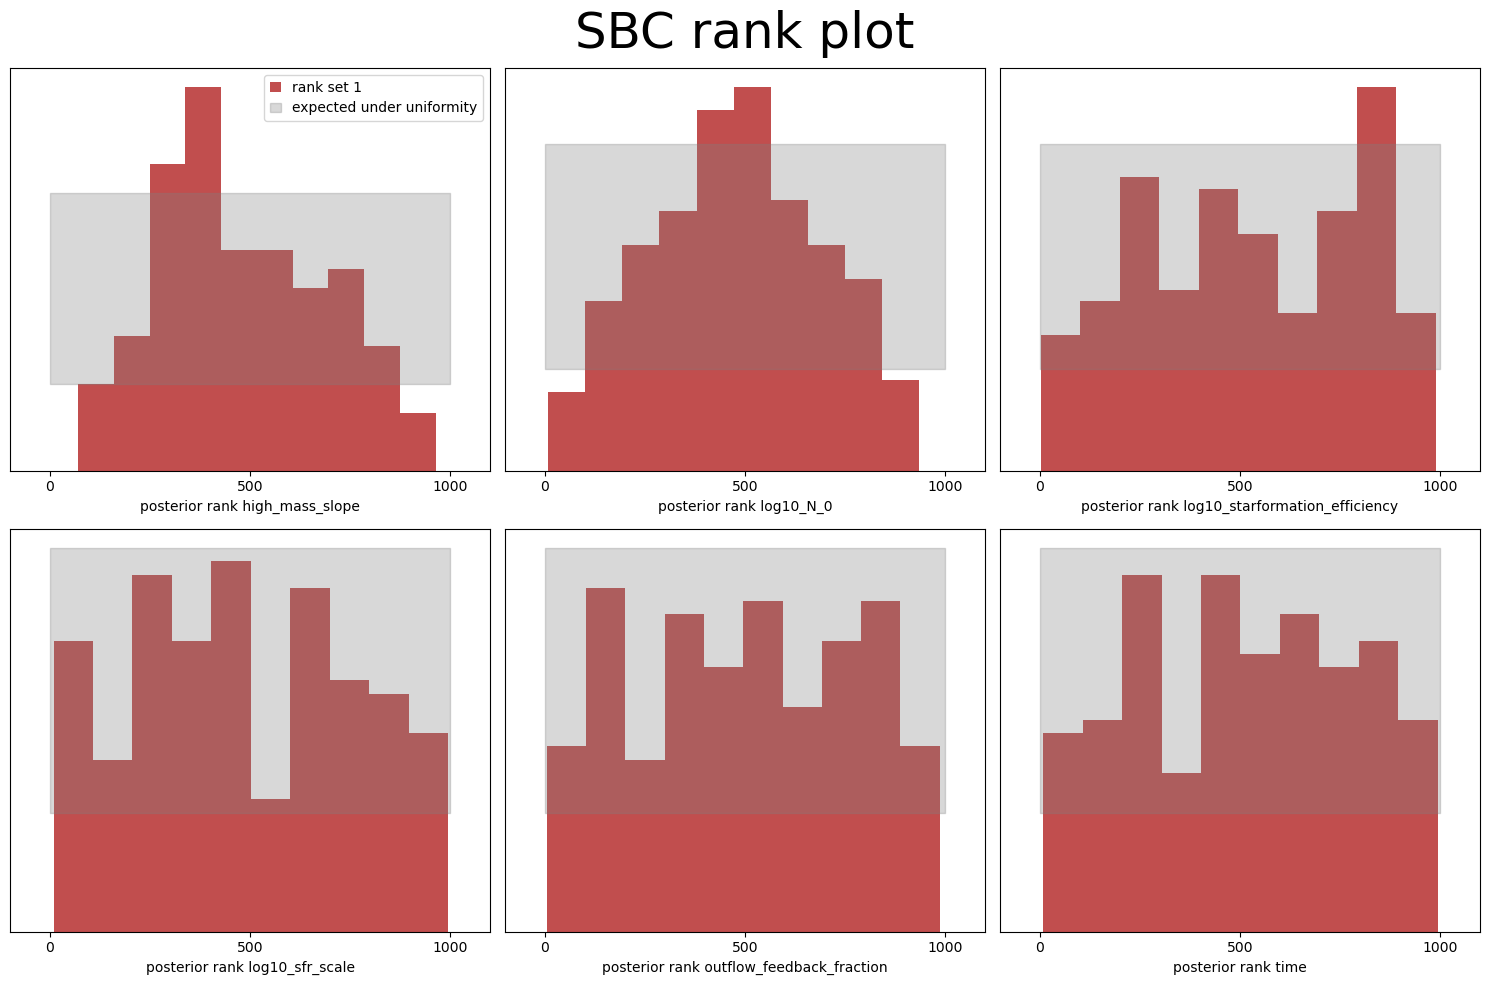

In [64]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    parameter_labels=labels,
    plot_type="hist",
    num_cols=3,
    figsize=(15,10),
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)
f.suptitle("SBC rank plot", fontsize=36)
plt.tight_layout()
plt.savefig('plots/sbc_rank_plot.png')
plt.show()

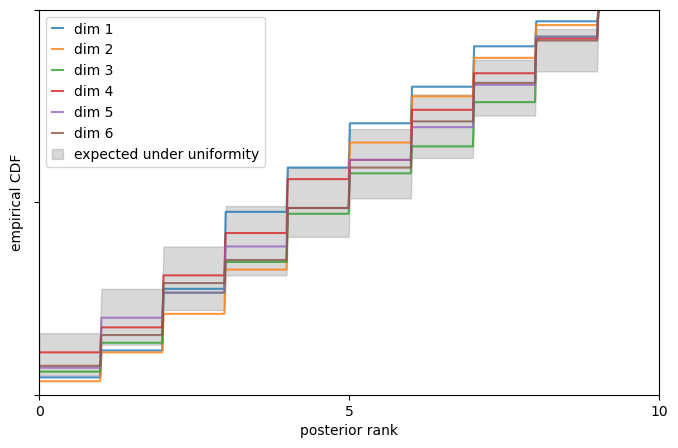

In [38]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")